In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt #for plotting

In [14]:
# using cuda enabled GPU  if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preparing/Creating Dataset

In [15]:
# downloading/loading MNIST train dataset
mnist_train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [16]:
print("Total number of Images in Dataset",len(mnist_train_data))

Total number of Images in Dataset 60000


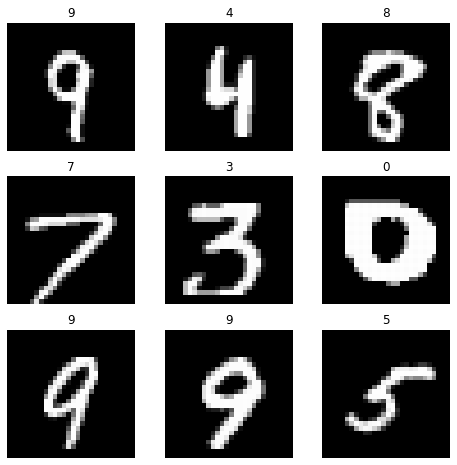

In [17]:
# plotting sample of dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
#randomly selecting index from dataset
rand_idx = torch.randint(len(mnist_train_data), size=(cols*rows,))
for i, idx in enumerate(rand_idx):
  #unpacking data set for img and label
  img, label = mnist_train_data[idx.item()]
  figure.add_subplot(rows, cols, i+1)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
# creating a custom data set for loading image and radom number
class CustomDataSet(Dataset):
  def __init__(self, mnist_dataset):
    self.mnist = mnist_dataset
    self.numbers = torch.randint(10, size=(len(self),))

  def __getitem__(self, index):
    #unpack img and label from mnist
    img, label = self.mnist[index]
    #get number from random number tensor
    number = self.numbers[index]
    #one hot encoding number
    num_onehot = F.one_hot(number, num_classes = 10).squeeze().float()
    #dictionary with input and target
    return {'input': [img.to(device), num_onehot.to(device)], 'target':[label, label + number.item()]}

  def __len__(self):
    return len(self.mnist)

In [19]:
#instantiating dataset
dataset = CustomDataSet(mnist_train_data)
#instantiating data loader with batch size 10
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [20]:
#get batch from data leader
batch = next(iter(data_loader))
inputs, targets = batch['input'], batch['target']
print("Image batch {0}, One-hot encoded Number {1}\n\
Handwritten digit label {2}, Sum of number and digit {3}".format(inputs[0].shape, inputs[1].shape, targets[0].shape, targets[1].shape))

Image batch torch.Size([10, 1, 28, 28]), One-hot encoded Number torch.Size([10, 10])
Handwritten digit label torch.Size([10]), Sum of number and digit torch.Size([10])


## Building Neural Network

![Network Architecture](https://raw.githubusercontent.com/chaitanya-vanapamala/pytorch_mnist_multi_label/main/netowrk%20architecture.png)

Let's Implement the network shown above using Pytorch.

In [21]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #CNN block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        #Random number block
        self.fc1 = nn.Linear(10, 64)

        #concated fc1 and flatten conv2
        self.fc2 = nn.Linear(in_features=12*4*4 + 64, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)

        #output layers
        self.out1 = nn.Linear(in_features=64, out_features=10)
        self.out2 = nn.Linear(in_features=64, out_features=19)

    def forward(self, t):
      #unpacking image and numbers
      images, numbers  = t
      
      # 1st Conv layer and MaxPool
      t1 = self.conv1(images)
      t1 = F.relu(t1)
      t1 = F.max_pool2d(t1, kernel_size=2, stride=2)

      # 2nd Conv layer and MaxPool
      t1 = self.conv2(t1)
      t1 = F.relu(t1)
      t1 = F.max_pool2d(t1, kernel_size=2, stride=2)

      # Flattening the conv output
      t1 = t1.reshape(-1, 12 * 4 * 4)

      # sending random number to FC1
      t2 = self.fc1(numbers)
      t2 = F.relu(t2)

      # concatination of t1 and t2
      t = torch.cat((t1, t2), 1)

      # Propagating concatinated tensor to fully connected layers
      t = self.fc2(t)
      t = F.relu(t)

      t = self.fc3(t)
      t = F.relu(t)

      # Out1 Image Digit Prediction
      o1 = self.out1(t)
      o1 = F.softmax(o1, dim=1)

      # Out2 Sum prediction
      o2 = self.out2(t)
      o2 = F.softmax(o2, dim=1)

      return o1, o2


In [22]:
#Let's see the network layers
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (out1): Linear(in_features=64, out_features=10, bias=True)
  (out2): Linear(in_features=64, out_features=19, bias=True)
)


In [23]:
print("Total Trainable Parameters:", sum(p.numel() for p in network.parameters() if p.requires_grad))

Total Trainable Parameters: 45709


## Loss Function

In [24]:
#computing loss function for two softmax outputs
def loss_function(outputs, t1, t2):
  #unpacking outputs
  o1, o2 = outputs
  #computing cross entropy loss
  l1 = nn.CrossEntropyLoss()(o1, t1)
  l2 = nn.CrossEntropyLoss()(o2, t2)

  #computing average loss
  return (l1+l2)/2

In [25]:
# correct predictions count
def right_predictions(outputs, t1, t2):
  digits = outputs[0].argmax(1).eq(t1).sum().item()
  sums = outputs[1].argmax(1).eq(t2).sum().item()
  return digits, sums

## Training Loop

In [26]:
#initalising data loader
train_dataset = CustomDataSet(mnist_train_data)
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#initialising network and assigning to GPU
network = Network()
network.to(device)
optimizer = optim.Adam(params = network.parameters(), lr=0.001)

#loss in each epoch
train_loss = []

for epoch in range(1, 51):
  total_loss = 0
  total_correct_digits = 0
  total_correct_sum = 0
  train_steps = 0
  for batch in train_data_loader:
    train_steps += 1
    inputs, targets = batch['input'], batch['target']
    t1, t2 = targets[0].to(device), targets[1].to(device)
    preds = network(inputs)
    loss = loss_function(preds, t1, t2)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    right_pred = right_predictions(preds, t1, t2)
    total_correct_digits += right_pred[0]
    total_correct_sum += right_pred[1]

  train_loss.append(total_loss/train_steps)
  print("epoch {0} => loss {1}, total correct digits {2}, total correct sums {3}".format(epoch, total_loss/train_steps, total_correct_digits, total_correct_sum))

epoch 1 => loss 2.295954925419171, total correct digits 46474, total correct sums 7400
epoch 2 => loss 2.1124475214527108, total correct digits 56388, total correct sums 20228
epoch 3 => loss 2.066591584860389, total correct digits 57842, total correct sums 23808
epoch 4 => loss 2.0407544788775414, total correct digits 58205, total correct sums 26450
epoch 5 => loss 2.0309157747703828, total correct digits 58422, total correct sums 27340
epoch 6 => loss 2.0055850537092703, total correct digits 58577, total correct sums 30263
epoch 7 => loss 1.9991911250645165, total correct digits 58753, total correct sums 30783
epoch 8 => loss 1.992365299511566, total correct digits 58919, total correct sums 31403
epoch 9 => loss 1.9731381881211612, total correct digits 58992, total correct sums 33669
epoch 10 => loss 1.9666050012940284, total correct digits 59043, total correct sums 34369
epoch 11 => loss 1.963268716706396, total correct digits 59170, total correct sums 34596
epoch 12 => loss 1.96279

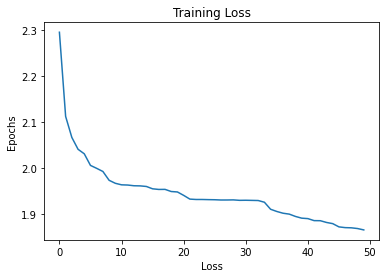

In [28]:
# let's plot the loss vs epoch
plt.plot(train_loss)
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Training Loss")
plt.show()

As we can see from the above graph our model is able to learn from the data and reducing the loss as number of epochs are increasing.

## Prediction on Test Data

In [29]:
#creating test data set
mnist_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataset = CustomDataSet(mnist_test_data)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [32]:
total_correct_digits = 0
total_correct_sum = 0
for batch in test_data_loader:
  inputs, targets = batch['input'], batch['target']
  t1, t2 = targets[0].to(device), targets[1].to(device)
  preds = network(inputs)

  right_pred = right_predictions(preds, t1, t2)
  total_correct_digits += right_pred[0]
  total_correct_sum += right_pred[1]

print("Accuracy : Digit Recognition : {0}, Sum : {1}".format(total_correct_digits*100/len(test_dataset), total_correct_sum*100/len(test_dataset)))

Accuracy : Digit Recognition : 98.84, Sum : 75.25


While the the labels of Images are recognized with high accuracy i.e., more then 98% on both test and train datasets, The sum of random and recognised label is only around 75% for both test and train dataset. 